In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

In [25]:
register_matplotlib_converters()
from statsmodels.tools.eval_measures import rmse
import warnings
# from statsmodels.tsa.arima_model import ARIMA

In [26]:
import statsmodels.api as sm

In [27]:
warnings.filterwarnings("ignore")

In [28]:
plt.style.use('fivethirtyeight')

In [29]:
df = pd.read_csv('NVDA.csv')

In [30]:
closePrices = df['Close'].to_numpy()

show closing prices with graphic

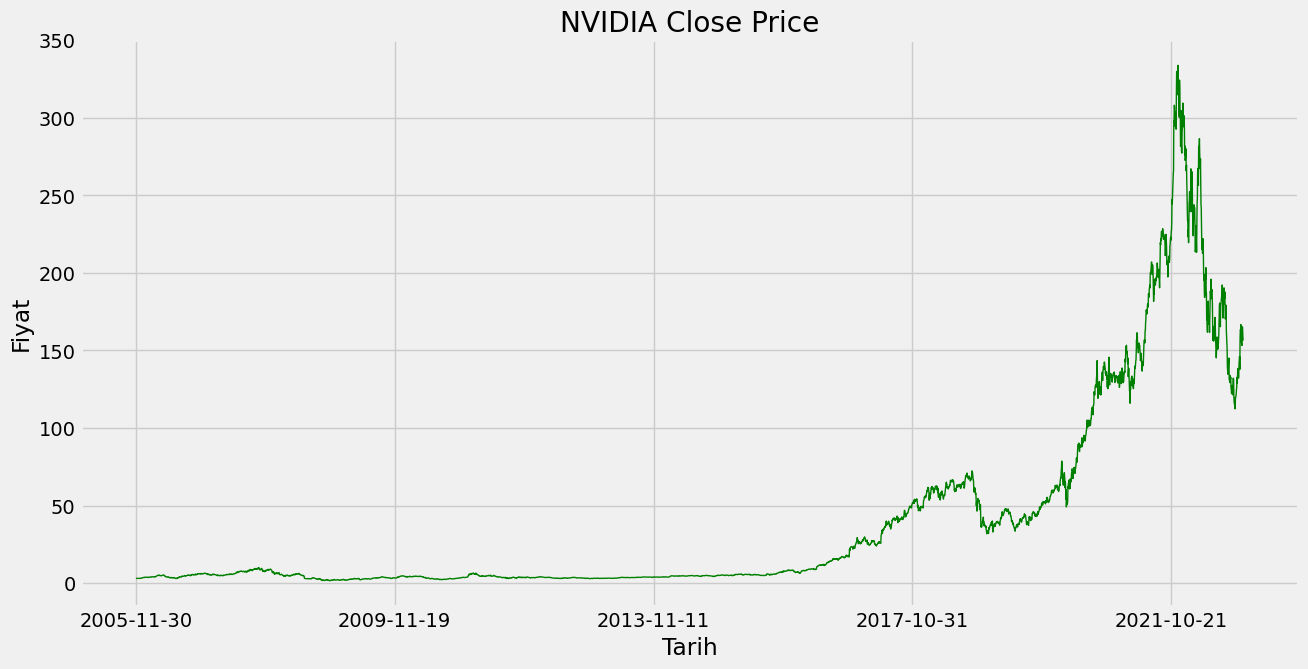

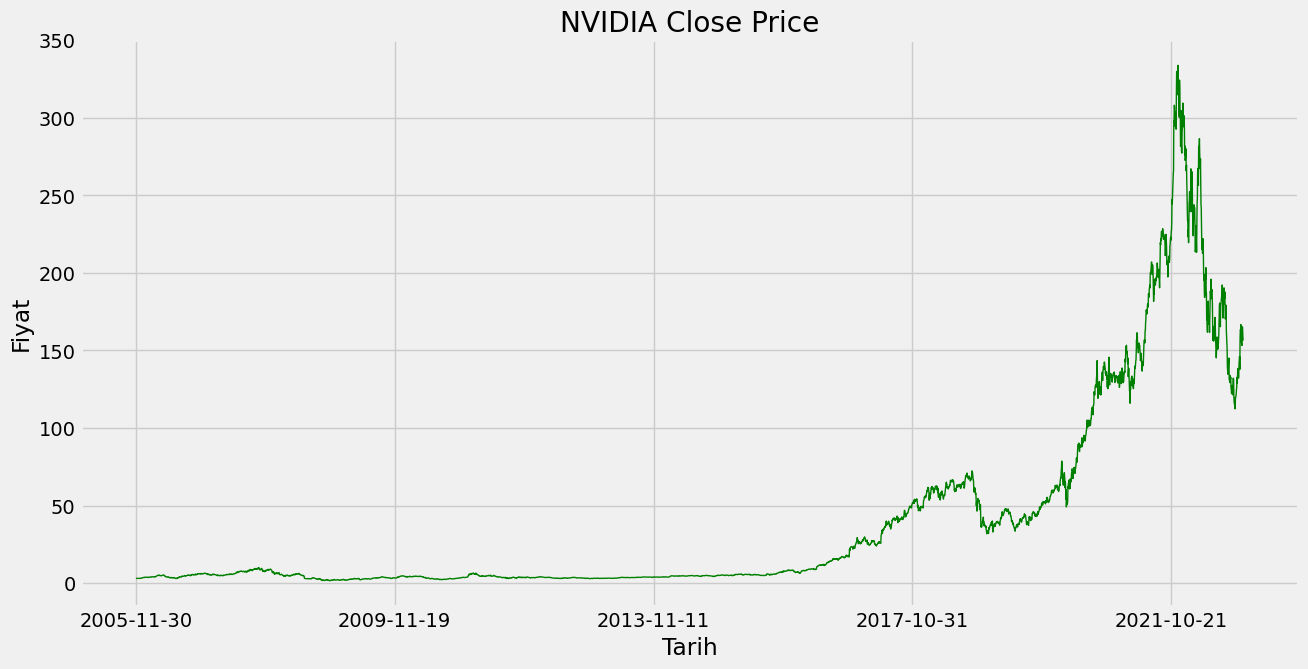

In [31]:
df.set_index("Date").Close.plot(linewidth=1, figsize=(14, 7), title="NVIDIA Close Price", color='green')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.show()

Creating a new feature for better representing day-wise values

In [32]:
df['Mean'] = (df['Low'] + df['High']) / 2

Cleaning the data for any NaN or Null fields

In [33]:
df = df.dropna()

Creating a copy for making small changes

In [34]:
dataset_for_prediction = df.copy()
dataset_for_prediction['Actual'] = dataset_for_prediction['Mean'].shift()
dataset_for_prediction = dataset_for_prediction.dropna()

date time typecast

In [35]:
dataset_for_prediction['Date'] = pd.to_datetime(dataset_for_prediction['Date'])
dataset_for_prediction.index = dataset_for_prediction['Date']

normalizing the exogeneous variables

In [36]:
from sklearn.preprocessing import MinMaxScaler

In [37]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['Low', 'High', 'Open', 'Close', 'Volume', 'Mean']])
scaled_input = pd.DataFrame(scaled_input, index=dataset_for_prediction.index)
X = scaled_input
X.rename(columns={0: 'Low', 1: 'High', 2: 'Open', 3: 'Close', 4: 'Volume', 5: 'Mean'}, inplace=True)
print("Normalized X")
print(X.head())

Normalized X
                 Low      High      Open     Close    Volume      Mean
Date                                                                  
2005-12-01  0.004915  0.004255  0.004608  0.004735  0.141582  0.004582
2005-12-02  0.004925  0.004277  0.004683  0.004737  0.079191  0.004598
2005-12-05  0.004844  0.004236  0.004663  0.004567  0.093786  0.004538
2005-12-06  0.004878  0.004207  0.004488  0.004604  0.090371  0.004539
2005-12-07  0.004769  0.004175  0.004545  0.004620  0.084179  0.004470
Normalized X
                 Low      High      Open     Close    Volume      Mean
Date                                                                  
2005-12-01  0.004915  0.004255  0.004608  0.004735  0.141582  0.004582
2005-12-02  0.004925  0.004277  0.004683  0.004737  0.079191  0.004598
2005-12-05  0.004844  0.004236  0.004663  0.004567  0.093786  0.004538
2005-12-06  0.004878  0.004207  0.004488  0.004604  0.090371  0.004539
2005-12-07  0.004769  0.004175  0.004545  0.004620 

normalizing the time series

In [38]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output = pd.DataFrame(scaler_output, index=dataset_for_prediction.index)
y = scaler_output
y.rename(columns={0: 'BTC Price next day'}, inplace=True)
y.index = dataset_for_prediction.index
print("Normalized y")
print(y.head())

Normalized y
            BTC Price next day
Date                          
2005-12-01            0.004423
2005-12-02            0.004582
2005-12-05            0.004598
2005-12-06            0.004538
2005-12-07            0.004539
Normalized y
            BTC Price next day
Date                          
2005-12-01            0.004423
2005-12-02            0.004582
2005-12-05            0.004598
2005-12-06            0.004538
2005-12-07            0.004539


train-test split (cannot shuffle in case of time series)

In [39]:
train_size = int(len(df) * 0.9)
test_size = int(len(df)) - train_size
train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

Init the best SARIMAX model

In [40]:
model = sm.tsa.arima.ARIMA(
    train_y,
    exog=train_X,
    order=(0, 1, 1)
)

training the model

In [41]:
results = model.fit()

get predictions

In [42]:
predictions = results.predict(start=train_size, end=train_size + test_size - 2, exog=test_X)

setting up for plots

In [43]:
act = pd.DataFrame(scaler_output.iloc[train_size:, 0])
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_X.index
predictions['Actual'] = act['BTC Price next day']
predictions.rename(columns={0: 'Pred', 'predicted_mean': 'Pred'}, inplace=True)

post-processing inverting normalization

In [44]:
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])

prediction plots

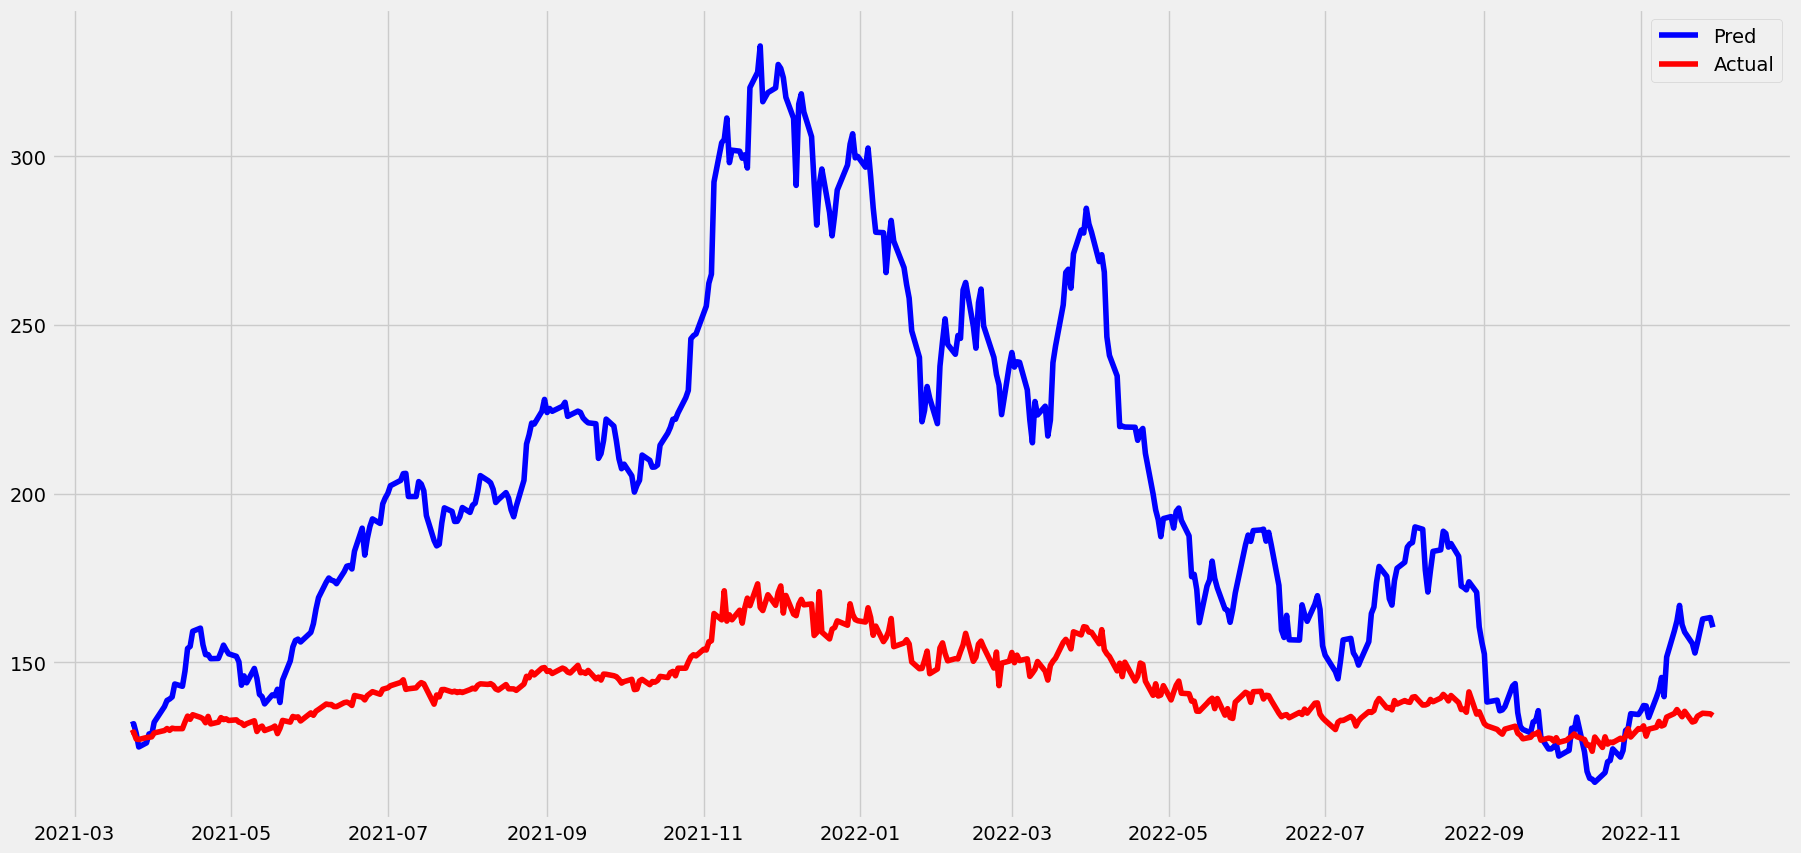

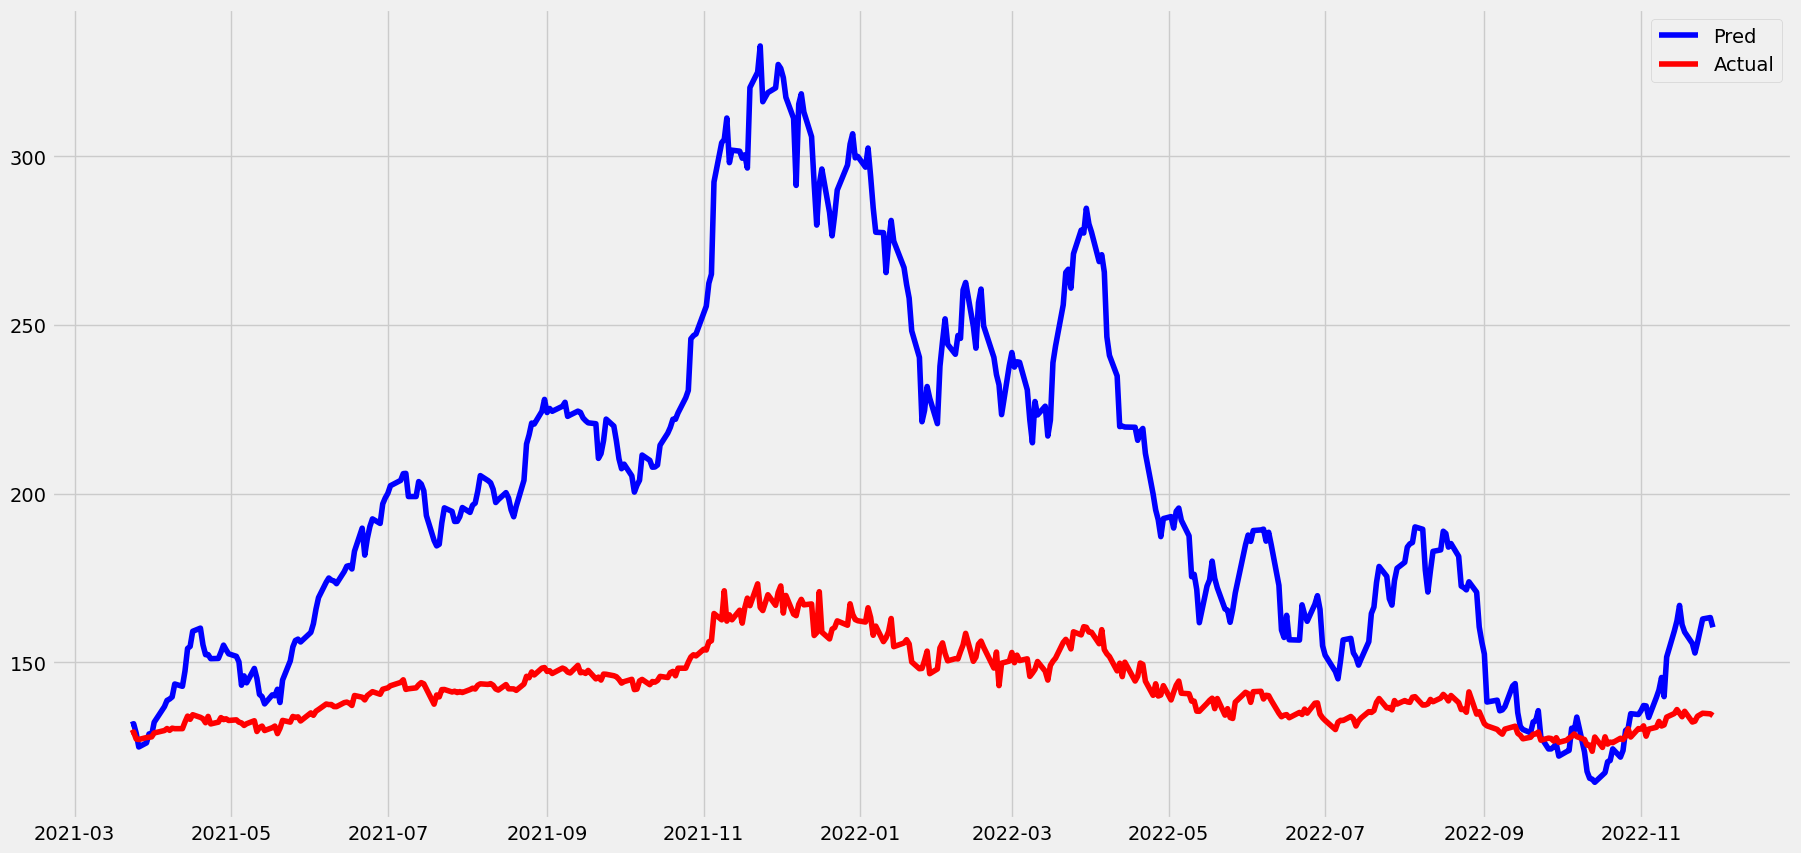

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(predictions.index, testActual, label='Pred', color='blue')
plt.plot(predictions.index, testPredict, label='Actual', color='red')
plt.legend()
plt.show()

print RMSE

In [46]:
print("RMSE:", rmse(testActual, testPredict))

RMSE: [70.11055866]
RMSE: [70.11055866]
